In this tutorial notebook, we focus on a specific example of a point cloud, to illustrate how to compute its GPDs using the provided code in the **utils.py** file.

I will show you how to:
- **create** a bifiltration from a given point cloud
- **generate a grid and a specific collection of intervals** on the grid
- **compute GRIs** with boundary zigzag filtration
- **calculate Möbius function** on the collection of intervals, which yield GPDs

## Setup

All the necessary code to compute GPDs can be found in the utils.py file.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
from multipers.data import noisy_annulus

## Define a point cloud and create a bifiltration 

We will work with the following point cloud. Feel free to consider your own point cloud.

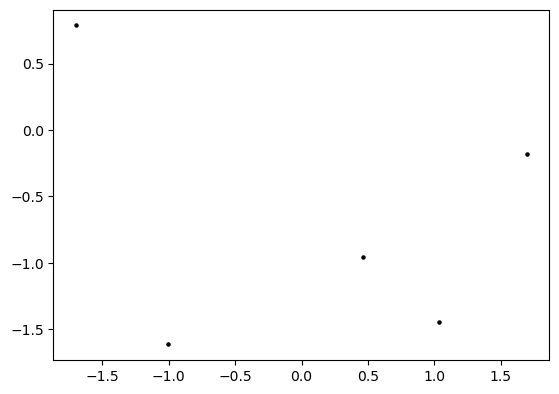

In [10]:
X = noisy_annulus(n1=3, n2=2)
plt.scatter(X[:,0], X[:,1], s=5, c='k');plt.gca().set_aspect(1);

In what follows, we create a bifiltration and 3x3 2D grid.

**Note:** the first parameter of the bifiltration is a rips and the second parameter is the log value of codensity.

For more details, refer to [Multipers documentation](https://www-sop.inria.fr/members/David.Loiseaux/doc/multipers/index.html)

In [11]:
bifiltration = utils.get_bifiltration(X)

grid = utils.get_grid(bifiltration, 3)

print(f'x-coordinates of the grid are {grid[0]}')
print(f'y-coordinates of the grid are {grid[1]}')

x-coordinates of the grid are [0.         1.76524892 3.53049784]
y-coordinates of the grid are [-0.3992636  -0.39910294 -0.39894228]


We will describe the bifiltration at every point in the grid. 

In [14]:
bifil_on_grid = utils.get_bifiltration_on_grid(bifiltration, grid)

Now, we will generate all (1, 1)-intervals and (2, 1)-intervals on the grid. 

Then, we will compute the generalized rank (GRI) over each interval by counting the number of bars fully supported on its boundary zigzag module. For more details, refer to [this paper](https://link.springer.com/article/10.1007/s00454-023-00584-z)

Note that the implementation works for d-dimension with $d = 0, 1$.

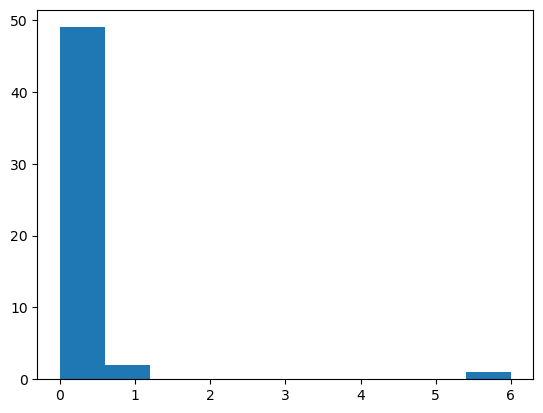

In [17]:
intervals = utils.get_int_2_1(grid)

GRIs = []
for intv in intervals:
    ZZ_persistence = utils.get_ZZpersistence(bifil_on_grid, intv, dimension=1)
    gri = utils.count_fullbar(ZZ_persistence)
    GRIs.append(gri)

plt.hist(GRIs)
plt.show()

Next, we will calculate Möbius function on the collection of intervals.

In [18]:
mobius_matrix = utils.mobius_matrix(intervals)

Finally, we will evaluate generlized persistence diagrams (GPDs) with the provided GRIs and the values of Möbius function.

For exact definition of GPDs, refer to [this paper](https://www.ams.org/journals/notices/202308/noti2761/noti2761.html).

Note that the GPDs is determined on only (1, 1)-intervals and (1, 2)-intervals of the grid, not ***all*** intervals.

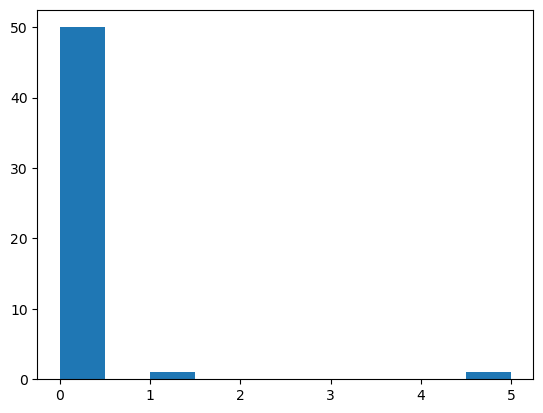

In [19]:
GRIs = np.array(GRIs)

GPDs = np.matmul(mobius_matrix, GRIs)

plt.hist(GPDs)
plt.show()